In [1]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from geoscilabs.mag.MagDipole import MagneticLongDipoleLine, MagneticLongDipoleField

### Define a magnetic dipole

A dipole is defined in the section below using
* dipoleloc: x, y, z location of the dipole center
* dipoledec: declination of the dipole's direction in degree; north = 0; positive clockwise
* dipoleinc: declination of the dipole's direction in degree; horizontal = 0; positive down
* dipoleL: length of the dipole *L* or the distance between two opposite charges *Q* that make the dipole
* dipolemoement: $m=\frac{QL}{\mu_0}$


In [2]:
# define a dipole
dipoleloc = (0.,0.,-50.)
dipoleL = 100.
dipoledec, dipoleinc = 0., 90.
dipolemoment = 1e13

### Define the Earth's magnetic field $B_0$
$B_0$ is used to calcualte the total field anomaly, which is the projection of the anomalous vector field onto the earth's field (inner product).
* B0: the magnitude of the earth's field
* Binc: inclination of the earth's field
* Bdec: declination of the earth's field

In [3]:
# geomagnetic field
B0, Binc, Bdec = 53600e-9, 90., 0. # in Tesla, degree, degree
B0x = B0*np.cos(np.radians(Binc))*np.sin(np.radians(Bdec))
B0y = B0*np.cos(np.radians(Binc))*np.cos(np.radians(Bdec))
B0z = -B0*np.sin(np.radians(Binc))

### Define the observations
Four data plots will be generated in the figure: magnetic anomalous field map (contour) at a certain elevation, magnetic anomalous field data (curve) along a x-profile and a y-profile, and the magnetic field lines of the dipole. 
* xmin, xmax, ymin, ymax: the outer bounds of the survey grid
* z: elevation at which the data map is measured
* profile_x, profile_y: x-coordinate of y-profile, y-coordinate of x-profile
* h: grid interval
* radii: how far the field lines expand; can plot multiple layers if given (r1, r2, ...)
* Naz: number of azimuth angles for the field line

In [4]:
# set observation grid
xmin, xmax, ymin, ymax, z = -5., 5., -5., 5., 1. # x, y bounds and elevation
profile_x = 0. # x-coordinate of y-profile
profile_y = 0. # y-coordinate of x-profile
h = 0.2 # grid interval
radii = (2., 5.) # how many layers of field lines for plotting
Naz = 10 # number of azimuth

### Calculate data for plotting

In [5]:
# get field lines
linex, liney, linez = MagneticLongDipoleLine(dipoleloc,dipoledec,dipoleinc,dipoleL,radii,Naz)

# get map
xi, yi = np.meshgrid(np.r_[xmin:xmax+h:h], np.r_[ymin:ymax+h:h])
x1, y1 = xi.flatten(), yi.flatten()
z1 = np.full(x1.shape,z)
Bx, By, Bz = np.zeros(len(x1)), np.zeros(len(x1)), np.zeros(len(x1))

for i in np.arange(len(x1)):
    Bx[i], By[i], Bz[i] = MagneticLongDipoleField(dipoleloc,dipoledec,dipoleinc,dipoleL,(x1[i],y1[i],z1[i]),dipolemoment)
Ba1 = np.dot(np.r_[B0x,B0y,B0z], np.vstack((Bx,By,Bz)))

# get x-profile
x2 = np.r_[xmin:xmax+h:h]
y2, z2 = np.full(x2.shape,profile_y), np.full(x2.shape,z)
Bx, By, Bz = np.zeros(len(x2)), np.zeros(len(x2)), np.zeros(len(x2))
for i in np.arange(len(x2)):
    Bx[i], By[i], Bz[i] = MagneticLongDipoleField(dipoleloc,dipoledec,dipoleinc,dipoleL,(x2[i],y2[i],z2[i]),dipolemoment)
Ba2 = np.dot(np.r_[B0x,B0y,B0z], np.vstack((Bx,By,Bz)))

# get y-profile
y3 = np.r_[ymin:ymax+h:h]
x3, z3 = np.full(y3.shape,profile_x), np.full(y3.shape,z)
Bx, By, Bz = np.zeros(len(x3)), np.zeros(len(x3)), np.zeros(len(x3))
for i in np.arange(len(x3)):
    Bx[i], By[i], Bz[i] = MagneticLongDipoleField(dipoleloc,dipoledec,dipoleinc,dipoleL,(x3[i],y3[i],z3[i]),dipolemoment)
Ba3 = np.dot(np.r_[B0x,B0y,B0z], np.vstack((Bx,By,Bz)))

### 3D plot of field lines and data
* Color bar in nT
* Spatial distance in meter
* Profile data only reflects shape of anomaly and positivity

<IPython.core.display.Javascript object>


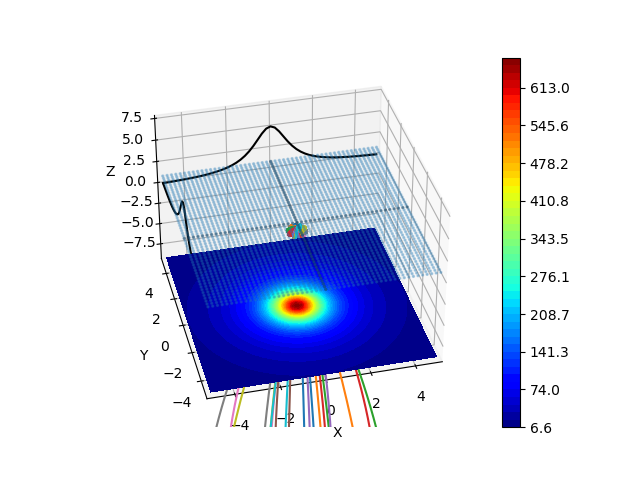

(-9.0, 7.5)

In [6]:
fig = plt.figure()

ax = fig.add_subplot(projection='3d')

# plot field lines
for lx,ly,lz in zip(linex,liney,linez):
    ax.plot(lx,ly,lz,'-',markersize=1)

# plot map
ax.scatter(x1,y1,z1,s=2,alpha=0.3)
Bt = Ba1.reshape(xi.shape)*1e9 # contour and color scale in nT 
c = ax.contourf(xi,yi,Bt,alpha=1,zdir='z',offset=z-max(radii)*2,cmap='jet',
                  levels=np.linspace(Bt.min(),Bt.max(),50,endpoint=True))
fig.colorbar(c)

# auto-scaling for profile plot
ptpmax = np.max((Ba2.ptp(),Ba3.ptp())) # dynamic range
autoscaling = np.max(radii) / ptpmax

# plot x-profile
ax.scatter(x2,y2,z2,s=2,c='black',alpha=0.3)
ax.plot(x2,Ba2*autoscaling,zs=ymax,c='black',zdir='y')

# plot y-profile
ax.scatter(x3,y3,z3,s=2,c='black',alpha=0.3)
ax.plot(y3,Ba3*autoscaling,zs=xmin,c='black',zdir='x')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_zlim(z-max(radii)*2, max(radii)*1.5)

